In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

# For data cleaning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
import shap
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [125]:
df = pd.read_csv('GlobalWeatherRepository.csv')
df.head()


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1.715849e+09,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1.0,1.0,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55.0
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1.715849e+09,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1.0,1.0,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55.0
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1.715849e+09,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1.0,1.0,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55.0
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1.715849e+09,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1.0,1.0,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55.0
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1.715849e+09,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5.0,10.0,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55.0


## Data Cleaning & Preprocessing

In [126]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Ni

Looks like there no null values in the dataset. But that doesn't mean there are no missing values. We need to check for missing values in multiple ways.

### Handling Missing Values



In [127]:
## Let's create a sample dataframe with different types of missing values

missing_indicators = {'N/A', 'NA', 'missing', 'unknown', '?', '', ' ', -999}

# Function to check missing values
def check_missing_values(df):
    missing_values = df.isin(missing_indicators)
    return missing_values.sum()

# Check for missing values in the sample dataframe


A    4
B    3
dtype: int64


### Looks like there are some missing values in the sample dataFrame. We would now replace the missing values from numerical dataframe with a median value and categorical columns with the most frequent value.

In [128]:
df.replace(missing_indicators, np.nan, inplace=True)

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Replacing the missing values in numeric columns with a median value 
df[numeric_cols] = SimpleImputer(strategy='median').fit_transform(df[numeric_cols])

# Replace missing values in categorical columns with the most frequent value.
df[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_cols])

In [129]:
df.to_csv('GlobalWeatherRepository.csv', index=False)

### Handling the Outliers
Outliers are basically data points that Significantly differ from rest of the data points, to make sure our data set doesn't have extreme values we will handle the outliers as necessary.

We can do so by using the IQR method. In this we divided the data points in quartiles with Q1 having values of 25th percentile and more and Q3 having values 75th percentile and less. We clip this middle 50% to ge the best possible dataset

In [130]:
def check_outlier(df,col):
    Q1 = df[col].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[col].quantile(0.75)  # Third quartile (75th percentile)

    IQR = Q3 - Q1  # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower_bound,upper_bound)
    return df


In [131]:
for col in numeric_cols:
    df = check_outlier(df, col)

## Normalize the data

In [132]:
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [133]:
df.describe()

,latitude,longitude,last_updated_epoch,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,...,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,moon_illumination
count,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,...,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04,6.099800e+04
mean,7.077995e-17,2.425826e-17,4.517802e-15,2.255174e-16,4.715363e-16,-1.060025e-16,1.155543e-16,1.258051e-16,6.333124e-15,-2.011484e-14,...,2.422914e-16,3.168426e-17,-1.565575e-16,-7.082363e-17,-1.258051e-16,2.236536e-17,-2.329725e-16,-1.192819e-16,-1.714677e-16,2.982048e-17
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,...,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-2.469254e+00,-1.901437e+00,-1.725594e+00,-2.441618e+00,-2.445272e+00,-1.174019e+00,-1.167624e+00,-1.621285e+00,-2.412059e+00,-2.304816e+00,...,-1.416735e+00,-2.602523e+00,-1.885998e+00,-7.831660e-01,-2.370214e+00,-1.048160e+00,-2.528608e+00,-8.001904e-01,-7.862367e-01,-1.431686e+00
25%,-6.286253e-01,-4.730638e-01,-8.573838e-01,-5.807972e-01,-5.830583e-01,-8.213099e-01,-8.144367e-01,-8.594388e-01,-6.139730e-01,-5.960722e-01,...,-7.471769e-01,-7.740708e-01,-7.151851e-01,-7.171395e-01,-7.233683e-01,-7.674448e-01,-7.594556e-01,-8.001904e-01,-7.862367e-01,-9.730187e-01
50%,-7.704955e-02,2.702187e-02,7.627646e-03,2.961412e-01,2.960729e-01,-2.530556e-01,-2.420292e-01,-8.794907e-02,-1.644516e-01,-1.300513e-01,...,-2.078108e-01,-3.394821e-01,-6.073062e-02,-5.333362e-01,-5.134762e-01,-3.595221e-01,-3.784758e-01,-8.001904e-01,-2.089546e-01,1.648624e-03
75%,8.688007e-01,4.791850e-01,8.638416e-01,6.597499e-01,6.584176e-01,6.287183e-01,6.348504e-01,8.378385e-01,5.847507e-01,5.430901e-01,...,6.105378e-01,4.448976e-01,6.057322e-01,4.053099e-01,3.745291e-01,4.583466e-01,4.199792e-01,3.897173e-01,3.683275e-01,9.763160e-01
max,1.839165e+00,1.907558e+00,1.718799e+00,2.520571e+00,2.520631e+00,2.803761e+00,2.808781e+00,1.840775e+00,2.382836e+00,2.251834e+00,...,2.647110e+00,2.273350e+00,2.587108e+00,2.088984e+00,2.021375e+00,2.297034e+00,2.189131e+00,2.174579e+00,2.100174e+00,1.434983e+00


Looks like we have successfully completed our data cleaning process. Let's save our updated csv file.

In [134]:
df.to_csv('GlobalWeatherRepository_cleaned.csv', index=False)

# Exploratory Data Analysis (EDA)

Lets have look at graphical visualization for temperature and precipitation.

I think it would be wise to use unscaled temperature and precipitation for the sake of the visualization to understand the trend better.

In [135]:
original_df = pd.read_csv('GlobalWeatherRepository.csv')
missing_indicators = {'N/A', 'NA', 'missing', 'unknown', '?', '', ' ', -999}
original_df.replace(missing_indicators, np.nan, inplace=True)
numeric_cols = original_df.select_dtypes(include=['number']).columns
original_df[numeric_cols] = SimpleImputer(strategy='median').fit_transform(original_df[numeric_cols])

# Calculate mean and std for temperature and precipitation
temp_mean = original_df['temperature_celsius'].mean()
temp_std = original_df['temperature_celsius'].std()
precip_mean = original_df['precip_mm'].mean()
precip_std = original_df['precip_mm'].std()

print(f"Temperature Mean: {temp_mean:.2f} °C, Std: {temp_std:.2f} °C")
print(f"Precipitation Mean: {precip_mean:.2f} mm, Std: {precip_std:.2f} mm")


Temperature Mean: 22.14 °C, Std: 9.62 °C
Precipitation Mean: 0.14 mm, Std: 0.61 mm


Now we can start with visualization for the temperature and precipitation.

In [136]:
df = pd.read_csv('GlobalWeatherRepository_cleaned.csv')
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Reverse normalization
df['temperature_celsius'] = (df['temperature_celsius'] * temp_std) + temp_mean
df['precip_mm'] = (df['precip_mm'] * precip_std) + precip_mean
df['precip_mm'] = df['precip_mm'].clip(lower=0)  # Ensure no negative precipitation

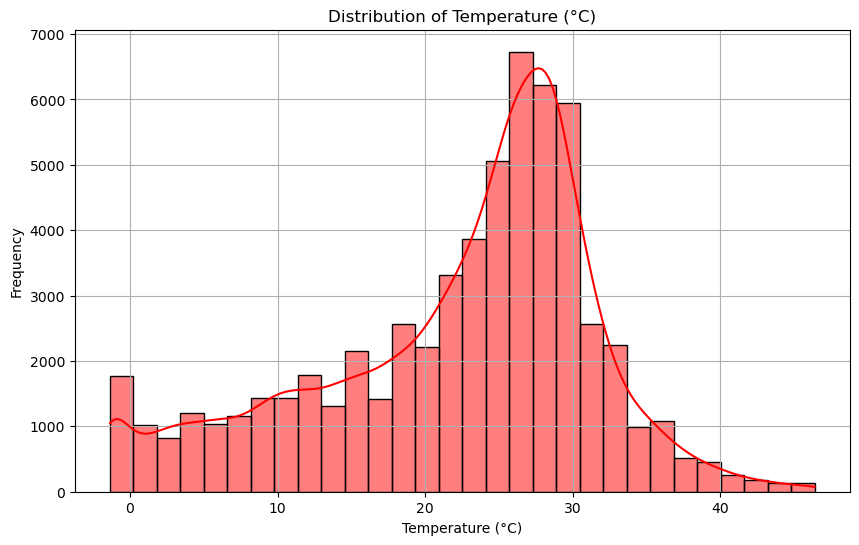

In [137]:
#Temperature Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['temperature_celsius'], bins=30, kde=True, color='red')
plt.title('Distribution of Temperature (°C)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

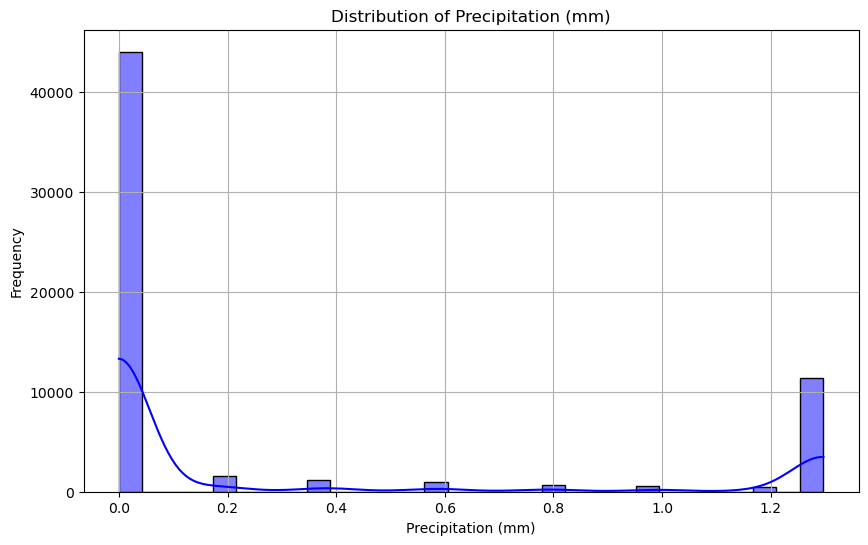

In [138]:
#Precipitation Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['precip_mm'], bins=30, kde=True, color='blue')
plt.title('Distribution of Precipitation (mm)')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

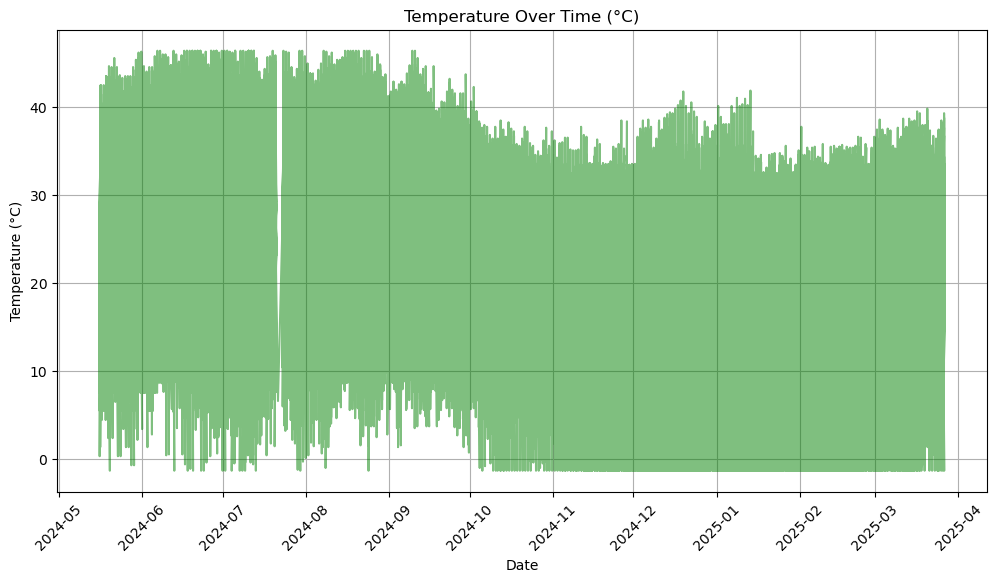

In [139]:
#Temperature vs. Time
plt.figure(figsize=(12, 6))
plt.plot(df['last_updated'], df['temperature_celsius'], 'g-', alpha=0.5)
plt.title('Temperature Over Time (°C)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

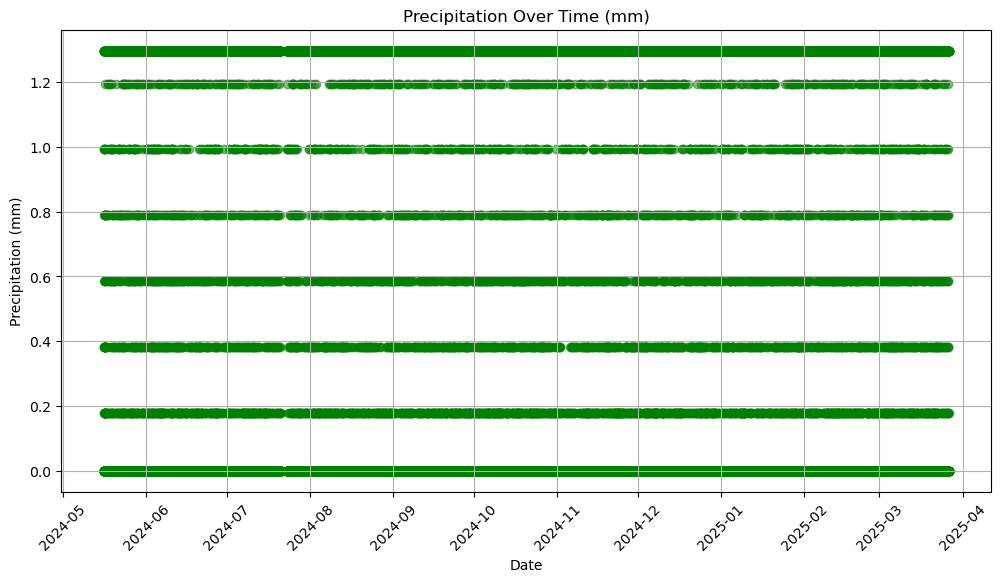

In [140]:
#Precipitation vs. Time
plt.figure(figsize=(12, 6))
plt.scatter(df['last_updated'], df['precip_mm'], color='green', alpha=0.5)
plt.title('Precipitation Over Time (mm)')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

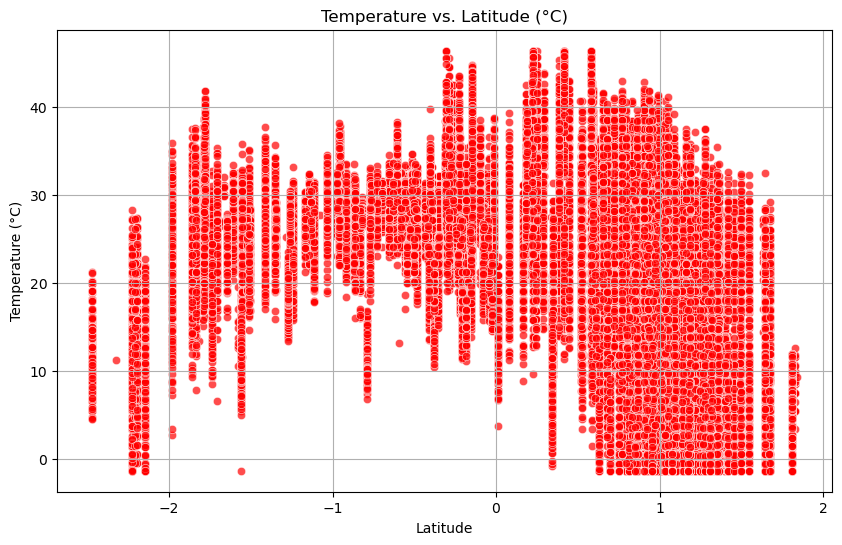

In [141]:
#Temperature vs. Latitude
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latitude', y='temperature_celsius', data=df, color='r', alpha=0.7)
plt.title('Temperature vs. Latitude (°C)')
plt.xlabel('Latitude')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

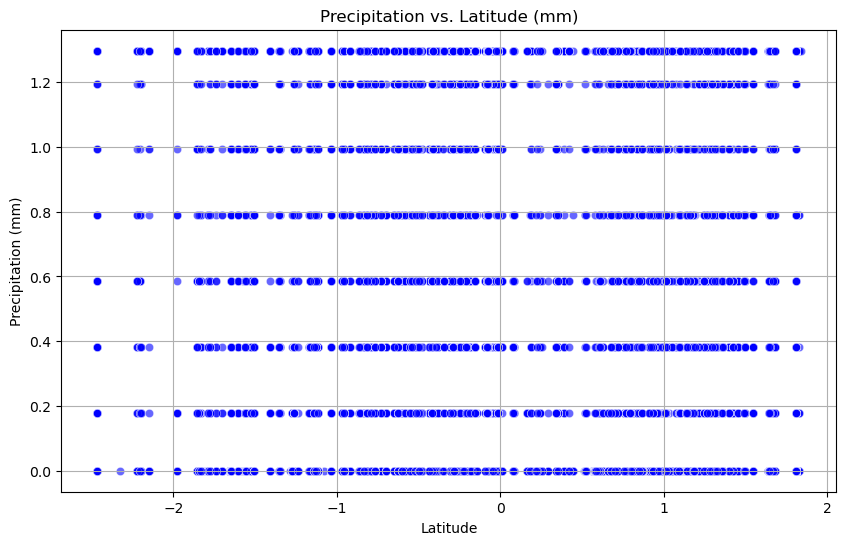

In [142]:
#Precipitation vs. Latitude
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latitude', y='precip_mm', data=df, color='b', alpha=0.6)
plt.title('Precipitation vs. Latitude (mm)')
plt.xlabel('Latitude')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.show()

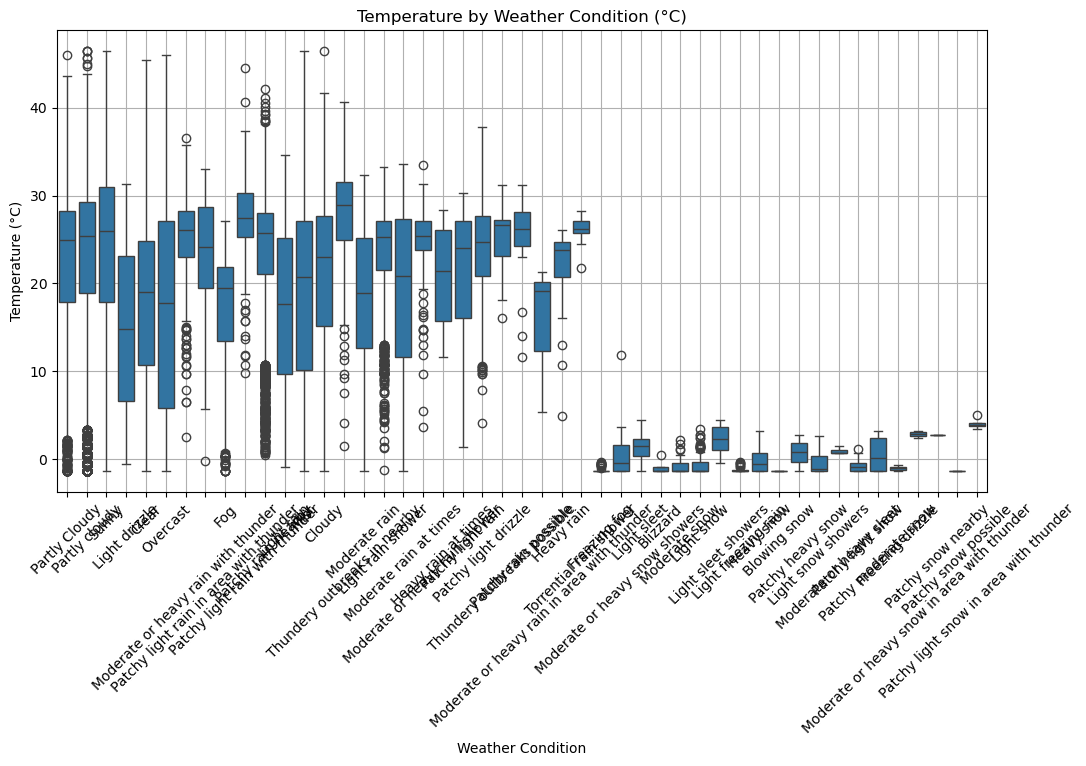

In [143]:
#Temperature by Weather Condition
plt.figure(figsize=(12, 6))
sns.boxplot(x='condition_text', y='temperature_celsius', data=df)
plt.title('Temperature by Weather Condition (°C)')
plt.xlabel('Weather Condition')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

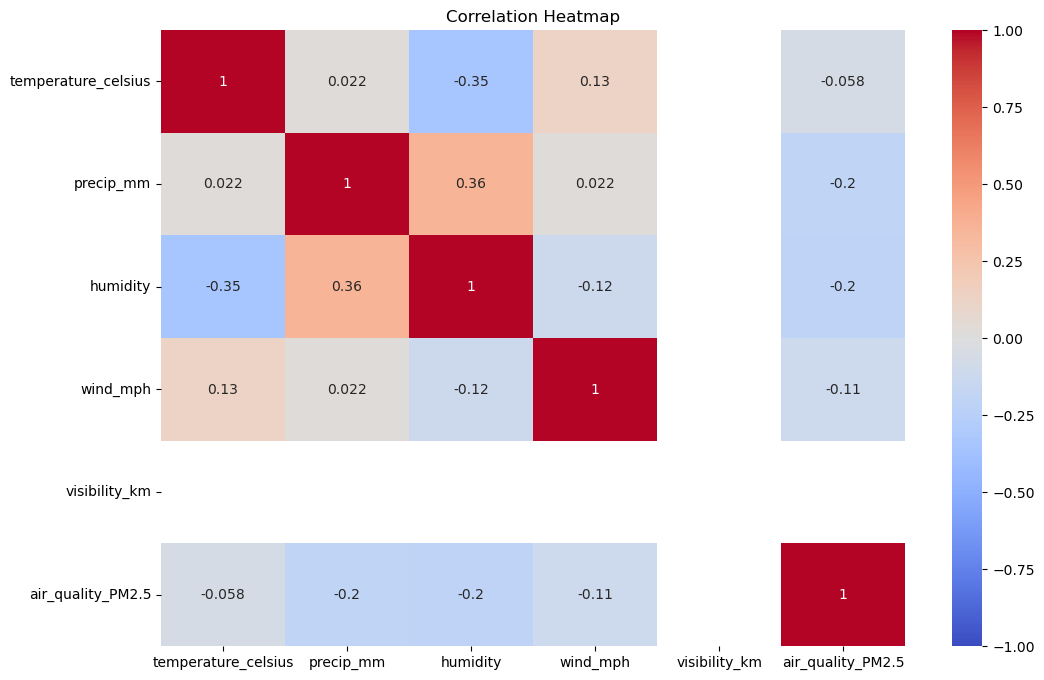

In [144]:
#Correlation Heatmap (only temp and precip unscaled)
plt.figure(figsize=(12, 8))
numeric_df = df[['temperature_celsius', 'precip_mm', 'humidity', 'wind_mph', 'visibility_km', 'air_quality_PM2.5']]
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Build a basic forecasting model and evaluate its performance using different metrics.


In [154]:
# Load cleaned (normalized) data
df = pd.read_csv('GlobalWeatherRepository_cleaned.csv')
df['last_updated'] = pd.to_datetime(df['last_updated'])

In [155]:
df = df.sort_values('last_updated')

In [156]:
# Extract time-based features from last_updated
df['month'] = df['last_updated'].dt.month
df['day'] = df['last_updated'].dt.day
df['hour'] = df['last_updated'].dt.hour

In [157]:
features = ['month', 'day', 'hour', 'humidity', 'precip_mm', 'wind_mph', 'latitude', 'condition_text']
X = df[features]
y = df['temperature_celsius']

# Encode categorical variable: condition_text
le = LabelEncoder()
X.loc[:, 'condition_text'] = le.fit_transform(X['condition_text'])

In [158]:
# Time-based train-test split (80% train, 20% test)
train_size = int(len(df) * 0.8)
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Scale numeric features
scaler = StandardScaler()
numeric_features = ['month', 'day', 'hour', 'humidity']
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (48798, 8)
Test set shape: (12200, 8)


Now that we have our train and test dataset, let's make some models and test them!!


Linear Regression Performance:
MSE: 0.94 (°C²)
MAE: 0.75 (°C)
R²: 0.19

Feature Coefficients:
          Feature  Coefficient
0           month    -0.031877
1             day     0.010757
2            hour     0.111597
3        humidity    -0.367816
4       precip_mm     0.116225
5        wind_mph     0.066015
6        latitude    -0.297835
7  condition_text     0.006081


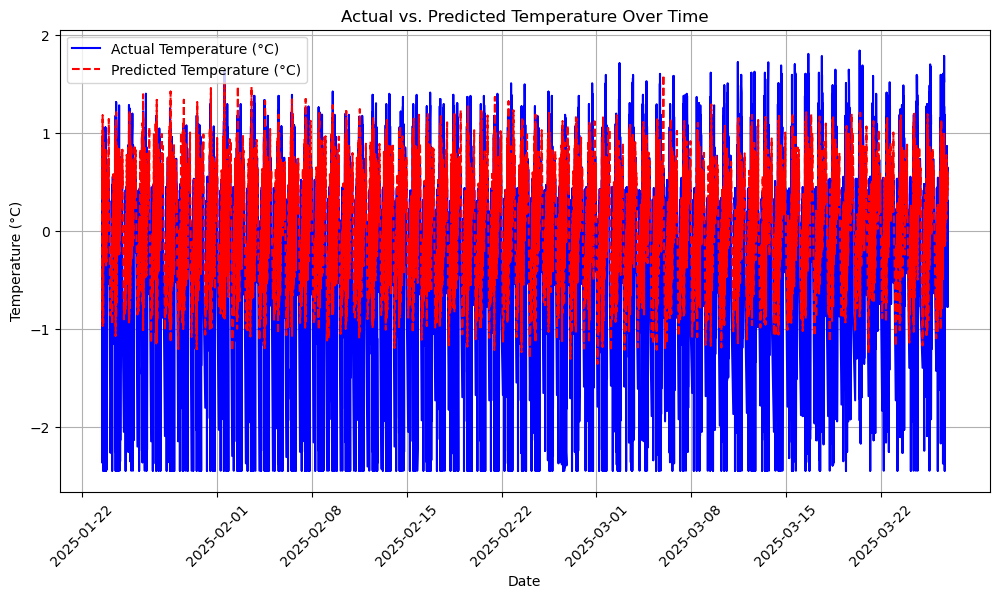

In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nLinear Regression Performance:")
print(f"MSE: {mse:.2f} (°C²)")
print(f"MAE: {mae:.2f} (°C)")
print(f"R²: {r2:.2f}")

# Coefficients (to show feature impact)
feature_names = ['month', 'day', 'hour', 'humidity', 'precip_mm', 'wind_mph', 'latitude', 'condition_text']
coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr.coef_})
print("\nFeature Coefficients:")
print(coefficients)

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(df['last_updated'].iloc[train_size:], y_test, label='Actual Temperature (°C)', color='blue')
plt.plot(df['last_updated'].iloc[train_size:], y_pred, label='Predicted Temperature (°C)', color='red', linestyle='--')
plt.title('Actual vs. Predicted Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

I think we can still improve the performance by changing our ML model. Lets build and compare Random Forest and SVR.

In [162]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf')  # Using RBF kernel for non-linear relationships
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MSE": mse, "MAE": mae, "R²": r2}
    
    print(f"\n{name} Performance:")
    print(f"MSE: {mse:.2f} (°C²)")
    print(f"MAE: {mae:.2f} (°C)")
    print(f"R²: {r2:.2f}")

# Feature importance for Random Forest
name = "Random Forest"
model = models[name]
importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
})
print(f"\n{name} Feature Importance:")
print(importances.sort_values(by='Importance', ascending=False))

# Plot actual vs. predicted for the best model (based on R²)
best_model_name = max(results, key=lambda x: results[x]["R²"])
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)



Random Forest Performance:
MSE: 0.16 (°C²)
MAE: 0.26 (°C)
R²: 0.86

SVR Performance:
MSE: 0.96 (°C²)
MAE: 0.74 (°C)
R²: 0.17

Random Forest Feature Importance:
          Feature  Importance
6        latitude    0.461732
0           month    0.197935
2            hour    0.178040
3        humidity    0.108617
5        wind_mph    0.021241
1             day    0.021161
7  condition_text    0.008762
4       precip_mm    0.002510


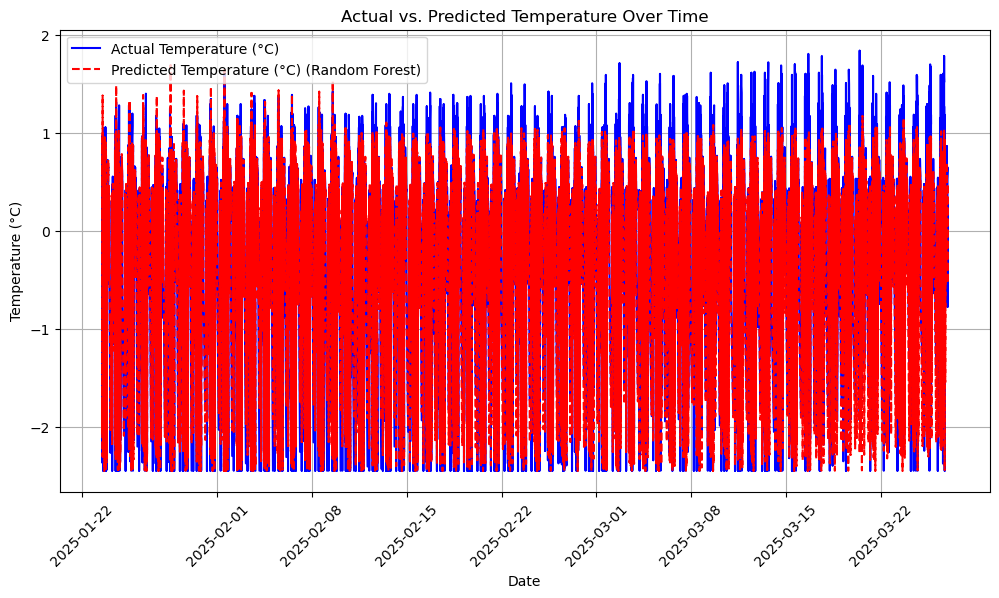

In [163]:

plt.figure(figsize=(12, 6))
plt.plot(df['last_updated'].iloc[train_size:], y_test, label='Actual Temperature (°C)', color='blue')
plt.plot(df['last_updated'].iloc[train_size:], y_pred_best, label=f'Predicted Temperature (°C) ({best_model_name})', color='red', linestyle='--')
plt.title('Actual vs. Predicted Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

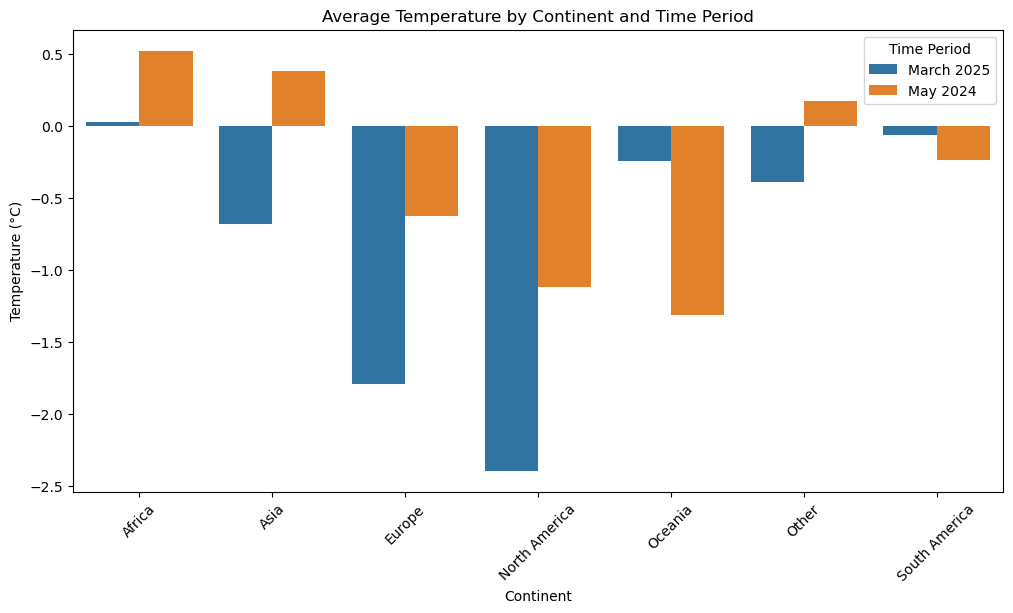

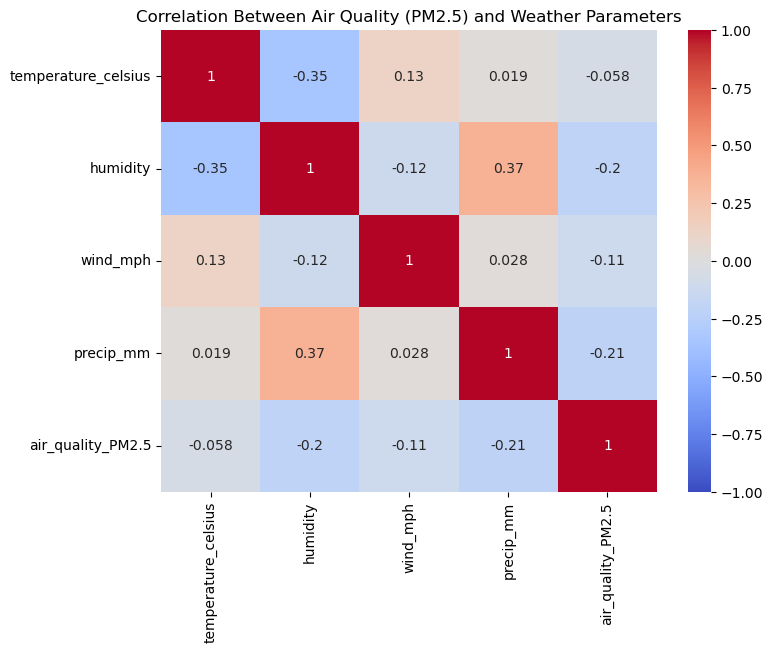


Permutation Importance:
             Feature  Importance
6           latitude    1.792400
2               hour    0.111465
3           humidity    0.080520
9  air_quality_PM2.5    0.023537
5           wind_mph    0.012304
7     condition_text    0.009686
1                day    0.003077
4          precip_mm    0.000513
0              month    0.000000
8      visibility_km    0.000000


In [ ]:
# Add continent
continent_mapping = {
    'United States': 'North America', 'Canada': 'North America',
    'Brazil': 'South America', 'Argentina': 'South America',
    'United Kingdom': 'Europe', 'Germany': 'Europe',
    'China': 'Asia', 'India': 'Asia',
    'Australia': 'Oceania',
    'South Africa': 'Africa', 'Egypt': 'Africa'
}
df['continent'] = df['country'].map(continent_mapping).fillna('Other')

# Extract time-based features
df['month'] = df['last_updated'].dt.month
df['day'] = df['last_updated'].dt.day
df['hour'] = df['last_updated'].dt.hour
df['time_period'] = df['last_updated'].apply(lambda x: 'May 2024' if x.year == 2024 else 'March 2025')
df['date'] = df['last_updated'].dt.date

features = ['month', 'day', 'hour', 'humidity', 'precip_mm', 'wind_mph', 'latitude', 'condition_text', 'visibility_km', 'air_quality_PM2.5']
X = df[features]
y = df['temperature_celsius']

# Encode categorical variable: condition_text
le = LabelEncoder()
X['condition_text'] = le.fit_transform(X['condition_text'])

# Time-based train-test split (80% train, 20% test)
train_size = int(len(df) * 0.8)
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Scale numeric features
scaler = StandardScaler()
numeric_features = ['month', 'day', 'hour', 'humidity', 'precip_mm', 'wind_mph', 'latitude', 'visibility_km', 'air_quality_PM2.5']
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 1. Climate Analysis
climate_stats = df.groupby(['time_period', 'continent']).agg({
    'temperature_celsius': 'mean',
    'humidity': 'mean',
    'precip_mm': 'mean'
}).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='continent', y='temperature_celsius', hue='time_period', data=climate_stats)
plt.title('Average Temperature by Continent and Time Period')
plt.xlabel('Continent')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend(title='Time Period')
plt.show()

# 2. Environmental Impact
weather_params = ['temperature_celsius', 'humidity', 'wind_mph', 'precip_mm']
correlations = df[weather_params + ['air_quality_PM2.5']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Air Quality (PM2.5) and Weather Parameters')
plt.show()

# 3. Feature Importance (Permutation and SHAP)
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({'Feature': features, 'Importance': perm_importance.importances_mean})
print("\nPermutation Importance:")
print(perm_df.sort_values(by='Importance', ascending=False))

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features)
plt.title('SHAP Feature Importance for Random Forest')
plt.show()

# 4. Spatial Analysis
fig = px.scatter_geo(
    df,
    lat='latitude',
    lon='longitude',
    color='temperature_celsius',
    size='humidity',
    hover_name='country',
    hover_data=['temperature_celsius', 'humidity', 'condition_text'],
    projection='natural earth',
    title='Temperature and Humidity Across the Globe'
)
fig.show()

# 5. Geographical Patterns
condition_by_continent = df.groupby(['continent', 'condition_text']).size().unstack(fill_value=0)
condition_by_continent = condition_by_continent.div(condition_by_continent.sum(axis=1), axis=0)
condition_by_continent.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Weather Conditions by Continent')
plt.xlabel('Continent')
plt.ylabel('Proportion of Observations')
plt.legend(title='Weather Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Time Series Trends
daily_temp = df.groupby(['continent', 'date'])['temperature_celsius'].mean().reset_index()
daily_temp['date'] = pd.to_datetime(daily_temp['date'])
plt.figure(figsize=(14, 8))
for continent in daily_temp['continent'].unique():
    subset = daily_temp[daily_temp['continent'] == continent]
    plt.plot(subset['date'], subset['temperature_celsius'], label=continent)
plt.title('Daily Average Temperature Trends by Continent')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Anomaly Detection
temp_stats = df.groupby(['continent', 'time_period'])['temperature_celsius'].agg(['mean', 'std']).reset_index()
temp_stats.columns = ['continent', 'time_period', 'temp_mean', 'temp_std']
df = df.merge(temp_stats, on=['continent', 'time_period'])
df['is_anomaly'] = (df['temperature_celsius'] > df['temp_mean'] + 2 * df['temp_std']) | (df['temperature_celsius'] < df['temp_mean'] - 2 * df['temp_std'])
plt.figure(figsize=(14, 8))
for continent in df['continent'].unique():
    subset = df[df['continent'] == continent]
    plt.scatter(subset['last_updated'], subset['temperature_celsius'], label=continent, alpha=0.5)
    anomalies = subset[subset['is_anomaly']]
    plt.scatter(anomalies['last_updated'], anomalies['temperature_celsius'], color='red', marker='x', s=100, label=f'{continent} Anomalies')
plt.title('Temperature Anomalies by Continent')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Predictive Insights
scenarios = pd.DataFrame({
    'month': [5, 3, 3],
    'day': [15, 15, 15],
    'hour': [12, 12, 12],
    'humidity': [60, 80, 40],
    'precip_mm': [0, 2, 0],
    'wind_mph': [10, 5, 15],
    'latitude': [40, -15, -30],
    'condition_text': ['Sunny', 'Light rain', 'Sunny'],
    'visibility_km': [10, 5, 15],
    'air_quality_PM2.5': [10, 20, 5]
})
scenarios['condition_text'] = le.transform(scenarios['condition_text'])
scenarios[numeric_features] = scaler.transform(scenarios[numeric_features])
predictions = rf.predict(scenarios)
scenarios['predicted_temperature'] = predictions
scenarios['country'] = ['United States', 'Brazil', 'Australia']
print("\nPredicted Temperatures for Hypothetical Scenarios:")
print(scenarios[['country', 'predicted_temperature']])